<center>
    
# 数据清洗和绘图观察数据

<br>
</center>
<img src='../static/img/logo.jpg' align='right' style="width:260px;height:60px;display:block"/>

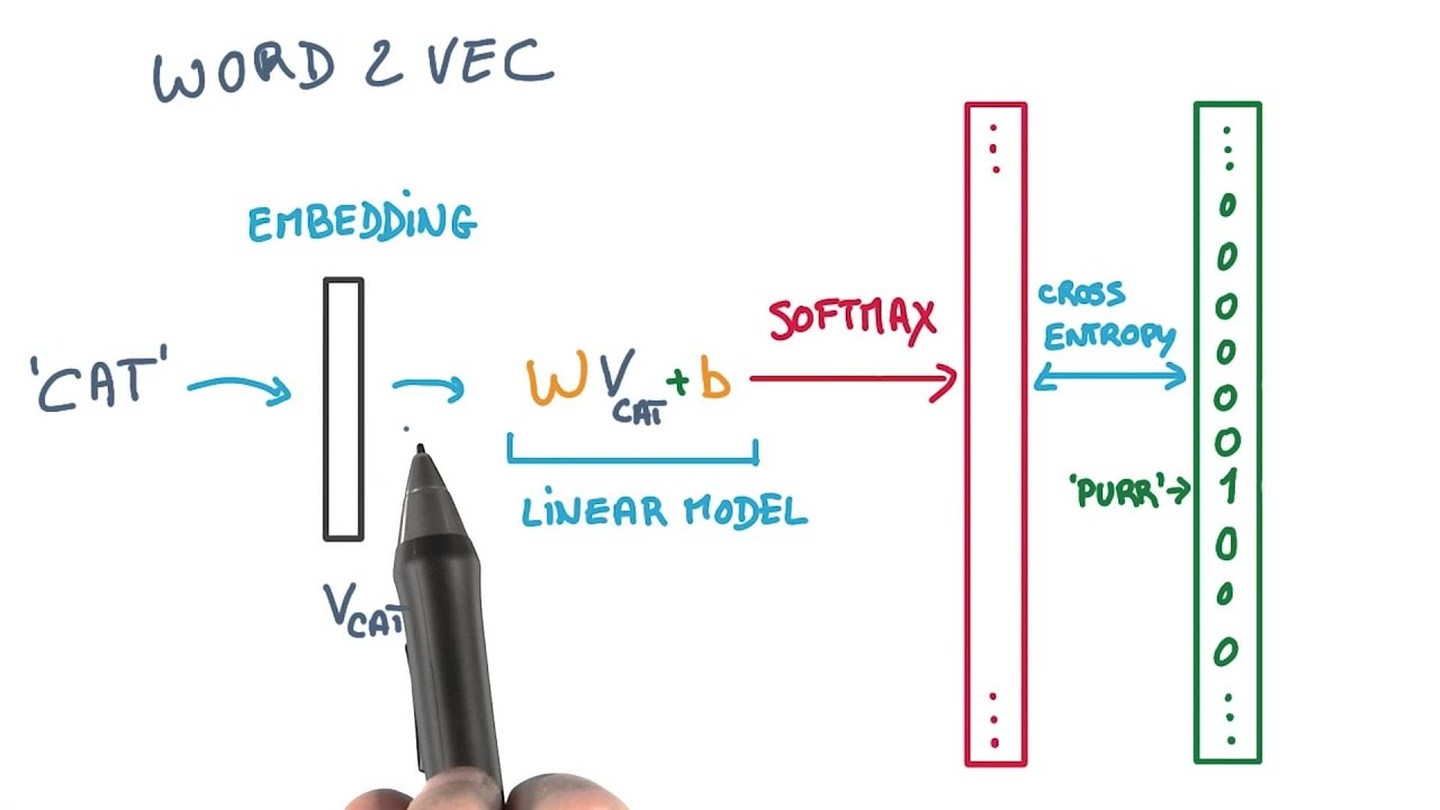



该demo实现目标:

- 绘制文章词云
- 利用word2vec查找具有高相关性的词语，并绘图显示

In [1]:
!pip install pyecharts==0.5.11 && pip install baidu-aip

  Using cached pyecharts-0.5.11-py2.py3-none-any.whl (122 kB)
     |████████████████████████████████| 829 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 520 kB 3.1 MB/s eta 0:00:01
  Using cached pyecharts_jupyter_installer-0.0.3-py2.py3-none-any.whl (4.7 kB)
     |████████████████████████████████| 540 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 1.1 MB/s eta 0:00:01
  Created wheel for jupyter-echarts-pypkg: filename=jupyter_echarts_pypkg-0.1.2-py3-none-any.whl size=522013 sha256=32ce2fe2443afce9c2e9b59ead97b74bf903f13224442e51319db4cdab9edf17
  Stored in directory: /home/jovyan/.cache/pip/wheels/5c/4c/f2/aecc470163ed58581211030229ed86305a50772d489694067a
  Created wheel for javascripthon: filename=javascripthon-0.11-py3-none-any.whl size=526625 sha256=53f4640ab18bc0225f378d44148677c846e266031b82296ab862f7bfa189def2
  Stored in directory: /home/jovyan/.cache/pip/wheels/8c/0d/7

In [7]:
import pandas as pd
import numpy as np
import warnings
import re
from sklearn.manifold import TSNE
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
from pyecharts import WordCloud
from collections import Counter
import multiprocessing
from gensim.models import Word2Vec
from aip import AipNlp
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

# 忽略警告
warnings.filterwarnings('ignore')

In [9]:
# 查看数据的基本格式
df = pd.read_csv('./data/JianShuJiaoYou-All-Data.csv',encoding='utf-8')
print(df.columns)
# df.head(5)

Index(['Page', 'Num', 'Author', 'Author_Url', 'Title', 'Time', 'Read',
       'Comment', 'Like', 'Abstract', 'Artical_Url', 'Image_Url',
       'Artical_Content'],
      dtype='object')


### 提取文章中200个关键词绘制词云

In [10]:
content = df['Artical_Content'].tolist()
# print(len(content),'\n',content[-1])

In [12]:
# 载入停用词
# quoting : int or csv.QUOTE_* instance, default 0
# 控制csv中的引号常量。可选 QUOTE_MINIMAL (0), QUOTE_ALL (1), QUOTE_NONNUMERIC (2) or QUOTE_NONE (3)
 
stopwords = pd.read_csv('./data/chinesestopword.txt',sep='\n',encoding='utf-8',names=['stopwords'],header=None,quoting=3)
# 默认输出5个
stopwords.head()

,stopwords
0,!
1,""""
2,#
3,$
4,%


In [13]:
# 结巴分词
pattern = re.compile('\d+')

# 存放词语和词频
wordsCounter = Counter()

for line in content:
    segs = jieba.lcut(line)
    for seg in segs:
        if len(seg)>1 and seg != '\r\n' and re.search(pattern,seg)==None:
            wordsCounter[seg] += 1

print(wordsCounter.most_common(100))

# 将Counter的键提取出来做list
segment = list(wordsCounter)

# 将分好的词列表转化为词典
words = pd.DataFrame({'segment':segment})

# 剔除停用词
words = words[~words['segment'].isin(stopwords['stopwords'])]

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.670 seconds.
DEBUG:jieba:Loading model cost 0.670 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


[('喜欢', 9535), ('一个', 9314), ('自己', 9078), ('我们', 7539), ('没有', 4949), ('可以', 4830), ('时候', 3910), ('知道', 3571), ('一起', 3481), ('因为', 3445), ('就是', 3358), ('什么', 3132), ('简书', 2948), ('生活', 2787), ('希望', 2735), ('还是', 2734), ('觉得', 2636), ('朋友', 2621), ('这个', 2549), ('不是', 2468), ('如果', 2450), ('现在', 2365), ('很多', 2363), ('所以', 2363), ('但是', 2321), ('这样', 2155), ('不会', 2069), ('文章', 1981), ('一直', 1926), ('开始', 1744), ('真的', 1697), ('那么', 1672), ('一样', 1622), ('时间', 1606), ('可能', 1567), ('他们', 1543), ('只是', 1539), ('看到', 1539), ('还有', 1507), ('其实', 1505), ('大家', 1490), ('故事', 1452), ('文字', 1448), ('工作', 1440), ('感觉', 1368), ('一些', 1360), ('别人', 1355), ('那个', 1344), ('一定', 1326), ('已经', 1290), ('事情', 1283), ('然后', 1267), ('我会', 1264), ('大学', 1231), ('世界', 1229), ('遇见', 1222), ('虽然', 1216), ('特别', 1189), ('爱情', 1166), ('不要', 1155), ('写作', 1151), ('东西', 1122), ('怎么', 1107), ('地方', 1103), ('一次', 1096), ('认识', 1082), ('这么', 1073), ('后来', 1062), ('这里', 1062), ('努力', 1060), ('可是', 1055), ('一下'

In [15]:
# 绘制词云
def counter2list(_counter):
    wordslist,nums = [],[]
    for item in _counter:
        wordslist.append(item[0])
        nums.append(item[1])
    return wordslist,nums

outputFile = './result/文章关键词词云图.html'

# 这个关键词抽取方法不唯一
wordslist,nums = counter2list(wordsCounter.most_common(1000))

cloud = WordCloud('文章关键词词云', width=1200, height=600, title_pos='center')
cloud.add(
    ' ',
    wordslist,nums,
    shape='circle',
    background_color='white',
    max_words=1000 
)

cloud.render(outputFile)

### word2vec模型计算词的相似度

In [16]:
# 基于TF-IDF算法的关键词抽取
contentStr = ''.join(content)
# keyWordsList = jieba.analyse.extract_tags(contentStr,topK=200,allowPOS=('ns','n'))
# textrank1 = ' '.join(keyWordsList)
# textrank1

In [17]:
# 基于TextRank算法进行关键词抽取
textrank2 = ' '.join(jieba.analyse.textrank(contentStr,topK=500,allowPOS=('ns','n')))
textrank2

'时候 简书 朋友 文章 大家 交友 时间 大学 文字 故事 简友 感觉 老师 我会 爱情 学校 专题 世界 职业 人生 投稿 电影 地方 有点 作者 城市 东西 同学 学生 树洞 地点 经历 事情 照片 读书 孩子 问题 专业 毕业 性格 姑娘 北京 校园 交流 小说 昵称 女生 上海 摄影 手机 内心 女孩 中国 个人 梦想 星座 父母 名字 男生 音乐 青春 年龄 家乡 时光 感情 文学 对方 文化 样子 无法 公司 美丽 素材 文艺 社会 记录 哥哥 灵魂 妈妈 单身 美食 日子 家庭 回家 情书 平台 心情 关系 结果 性别 原因 能力 眼睛 方面 咖啡 编辑 唱歌 游戏 评论 小时 现实 画画 声音 小时候 历史 姐姐 情感 理想 方式 跑步 男人 想象 凡人 图书馆 内容 时代 见面 大赛 身体 衣服 宿舍 嘉宾 女人 总会 公众 风景 学会 陌生 兴趣 基本 学历 精神 成都 先生 好友 校友 习惯 作品 教室 艺术 思想 小学 男朋友 线下 联系 社群 武汉 家人 信息 模样 礼物 世间 长大 味道 陌生人 广州 父亲 朋友圈 印象 机会 女性 体重 空间 妹子 玫瑰 记忆 婚姻 人们 重庆 热情 杭州 计划 情况 读者 男孩 西安 小伙伴 励志 会员 少女 火车 体验 深圳 幻想 人物 陪伴 情绪 人家 意义 室友 大学生 国家 女孩子 山东 状态 程序员 天空 链接 思维 标准 所在地 写字 女朋友 散文 话题 吉他 女子 江湖 心灵 过程 账号 传统 江南 云南 全部 书籍 羽毛球 力量 南京 建筑 母亲 代表 爸爸 建议 材质 白色 自我介绍 公园 技术 电话 缺点 学院 产生 大神 笔名 情侣 目标 距离 图片 独家 民谣 校区 气息 主题 粉丝 心理 动漫 无戒 妹妹 姓名 樱花 方向 脾气 成绩 颜值 整理 日本 作家 苏州 湖南 舍友 天津 诗歌 农村 河南 电脑 教师 鸡汤 爱好者 产品 心理学 黑色 语文 操场 老家 大海 网络 环境 四川 中心 研究生 太阳 广东 中学 篮球 行业 女儿 经济 古风 缘分 理性 风格 典型 蓝色 视频 时期 绘画 女神 写文章 头发 友情 同事 体会 新疆 老板 湖北 男女 闺蜜 房子 书写 领导 用心 大理 大叔 地址 条件 对象 人间 浓情 互联网 信号 生气 部分 帅气 外表 美女 形式

In [18]:
# 利用word2vec找出关联词语，将语料整理成嵌套列表的形式
corpus = []

# 将停用词dataFrame转化为列表
stopwordsList = stopwords['stopwords'].tolist()
# print(stopwordsList[:10])
for line in content:
    segs = jieba.lcut(line)
    segs = filter(lambda x:len(x)>1, segs)
    segs = filter(lambda x:re.search(pattern,x)==None, segs)
    segs = filter(lambda x:x not in stopwordsList, segs)
    
    corpus.append(list(segs))

In [19]:
# 训练模型
model = Word2Vec(corpus,min_count=20,sg=0,workers=multiprocessing.cpu_count())
# 查询和简书相关性比较高的词语
model.wv.most_similar(['简书'],topn=15)

[('平台', 0.9520959258079529),
 ('小伙伴', 0.9080962538719177),
 ('书上', 0.9066888689994812),
 ('简书里', 0.8918504118919373),
 ('签约', 0.8826266527175903),
 ('注册', 0.8763467073440552),
 ('训练营', 0.8763159513473511),
 ('篇文章', 0.8757615089416504),
 ('创作', 0.8750913143157959),
 ('这篇', 0.8734336495399475),
 ('辩论', 0.8696433305740356),
 ('一位', 0.8674404621124268),
 ('第一篇', 0.8665637373924255),
 ('专题', 0.866013765335083),
 ('读者', 0.8634032011032104)]

### t-SNE 可视化高维数据
t-SNE是目前最为流行的一种高维数据降维的算法

In [20]:
# 调用百度云NLP进行词向量表示
APP_ID = '11617353'
API_KEY = 'eV2R48IOWKcLgBrZwtf0ZF7N'
SECRET_KEY = 'HHtuGb3BPGaXAguPld5r9gfrY4xCCdzh'
client = AipNlp(APP_ID, API_KEY, SECRET_KEY)

In [21]:
# 获取textrank2中Top200词语的词向量
textrankList = textrank2.split(' ')

In [22]:
# 整理格式 原始格式：('简书', 0.9286492277441794) 后者是特征权重
words_list = []
word_vectors = []

for word in textrankList:
    try:
        data = client.wordEmbedding(word)
#         print(data)
        word_vector = data['vec']
        words_list.append(data['word'])
        word_vectors.append(word_vector)
    except:
        print('No words:{}'.format(word))
    
word_vectors = np.array(word_vectors)
# print(words_list)

No words:简书
No words:朋友
No words:文章
No words:时间
No words:大学
No words:文字
No words:故事
No words:简友
No words:我会
No words:爱情
No words:学校
No words:专题
No words:世界
No words:投稿
No words:电影
No words:地方
No words:有点
No words:作者
No words:城市
No words:学生
No words:树洞
No words:地点
No words:经历
No words:事情
No words:照片
No words:读书
No words:孩子
No words:毕业
No words:性格
No words:姑娘
No words:北京
No words:校园
No words:交流
No words:小说
No words:上海
No words:摄影
No words:手机
No words:内心
No words:个人
No words:梦想
No words:星座
No words:父母
No words:名字
No words:男生
No words:音乐
No words:家乡
No words:时光
No words:感情
No words:文学
No words:对方
No words:文化
No words:公司
No words:美丽
No words:素材
No words:文艺
No words:社会
No words:灵魂
No words:妈妈
No words:单身
No words:美食
No words:日子
No words:家庭
No words:平台
No words:心情
No words:关系
No words:结果
No words:性别
No words:原因
No words:能力
No words:眼睛
No words:游戏
No words:评论
No words:小时
No words:现实
No words:画画
No words:声音
No words:小时候
No words:情感
No words:理想
No words:方式
No words:跑步
No words:男人
No words:想象
No 

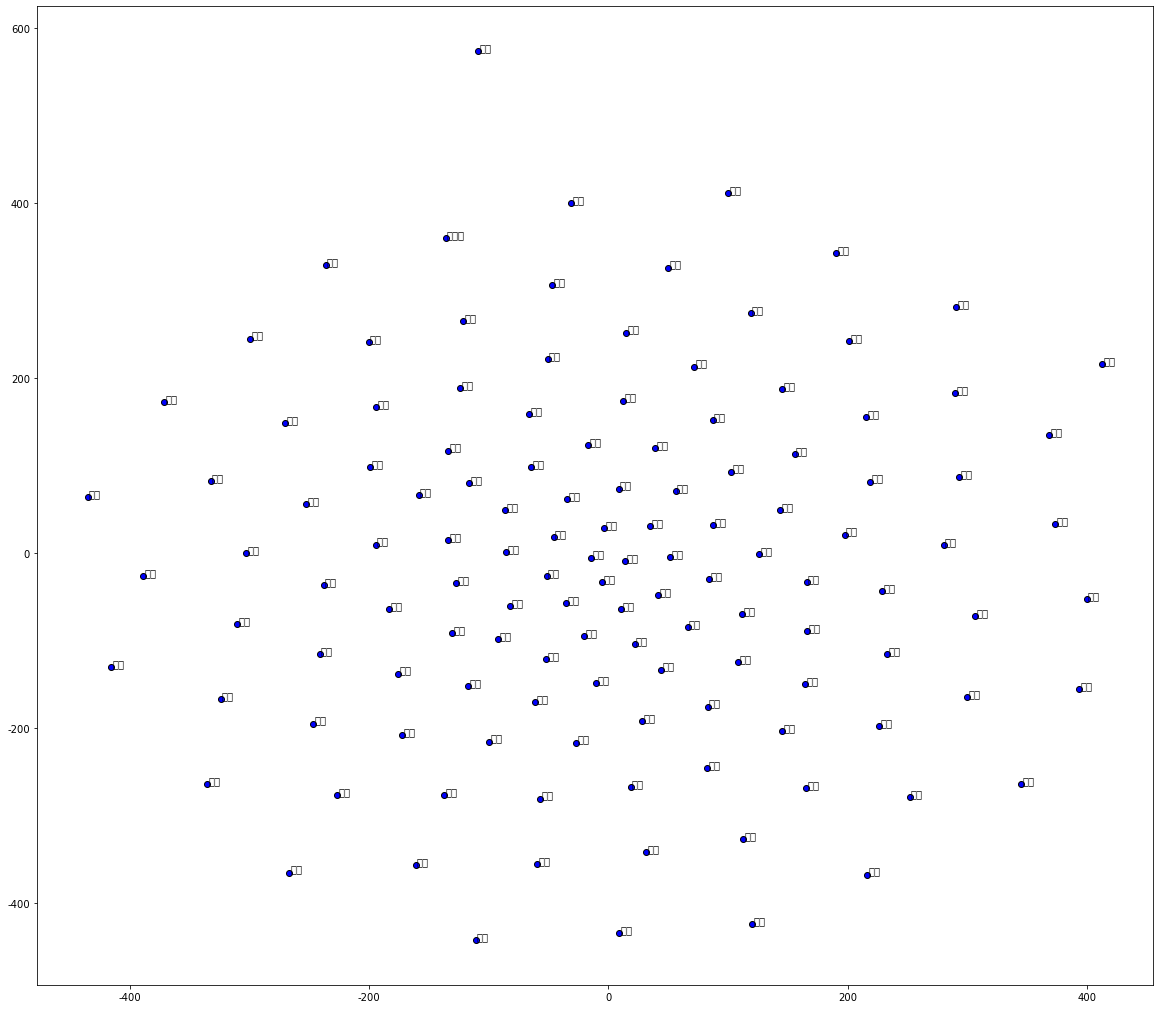

In [24]:
def plotTsne2D(word_vectors,words_list):
    tsne = TSNE(n_components=2,random_state=0,n_iter=10000,perplexity=20)
    # 在控制台输出过程中，默认小数会以科学计数法的形式输出，若不需要加上下面这句
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)
    labels = words_list
    
    plt.figure(figsize=(20,18))
    plt.scatter(T[:,0],T[:,1],c='blue',edgecolors='k')
    
    for label,x,y in zip(labels,T[:,0],T[:,1]):
        plt.annotate(label,xy=(x+1,y+1),xytext=(0,0),textcoords='offset points')

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['Kai']
plt.rcParams['axes.unicode_minus'] = False

plotTsne2D(word_vectors,words_list)